In [ ]:
import pandas as pd

df = pd.read_csv('drive/MyDrive/Dicoding/BPML/Submission 1/dataset_review_tokped.csv')
df.head(5)

,Unnamed: 0,Review,Rating
0,0,maaantap,5
1,1,Enak & segar,5
2,2,maknyus,5
3,3,Dari berat 500 gram yg remuk 59 gram.\nEntah d...,4
4,4,"enak banget, fresh dan renyah!",5


In [ ]:
del df['Unnamed: 0']
df

,Review,Rating
0,maaantap,5
1,Enak & segar,5
2,maknyus,5
3,Dari berat 500 gram yg remuk 59 gram.\nEntah d...,4
4,"enak banget, fresh dan renyah!",5
...,...,...
5423,"good product, trusted seller 👍👍",5
5424,sudah beli yg ke 3 ..,5
5425,byk campurannya,4
5426,good,5


In [ ]:
# Mencari tahu info data seperti jumlah abris, kolom, tipe data, nilai null 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5428 entries, 0 to 5427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  5123 non-null   object
 1   Rating  5428 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 84.9+ KB


In [ ]:
df = df.astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5428 entries, 0 to 5427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  5123 non-null   object
 1   Rating  5428 non-null   object
dtypes: object(2)
memory usage: 84.9+ KB


In [ ]:
df.isnull().sum()

Review    305
Rating      0
dtype: int64

In [ ]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5123 entries, 0 to 5427
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  5123 non-null   object
 1   Rating  5123 non-null   object
dtypes: object(2)
memory usage: 120.1+ KB


In [ ]:
df.Rating.value_counts()

5    4589
4     282
3     130
1      68
2      54
Name: Rating, dtype: int64

In [ ]:
kategori = pd.get_dummies(df.Rating)
df = pd.concat([df, kategori], axis=1)
df.drop(df.columns[[1]], axis=1, inplace=True)
df

,Review,1,2,3,4,5
0,maaantap,0,0,0,0,1
1,Enak & segar,0,0,0,0,1
2,maknyus,0,0,0,0,1
3,Dari berat 500 gram yg remuk 59 gram.\nEntah d...,0,0,0,1,0
4,"enak banget, fresh dan renyah!",0,0,0,0,1
...,...,...,...,...,...,...
5423,"good product, trusted seller 👍👍",0,0,0,0,1
5424,sudah beli yg ke 3 ..,0,0,0,0,1
5425,byk campurannya,0,0,0,1,0
5426,good,0,0,0,0,1


In [ ]:
ulasan = df['Review'].values
print(ulasan)

['maaantap' 'Enak & segar' 'maknyus' ... 'byk campurannya' 'good' 'good']


In [ ]:
from sklearn.model_selection import train_test_split

ulasan_latih, ulasan_test, kategori_latih, kategori_test = train_test_split(ulasan, kategori, test_size=0.2, shuffle=True)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(ulasan_latih)
tokenizer.fit_on_texts(ulasan_test)

In [ ]:
sekuens_latih = tokenizer.texts_to_sequences(ulasan_latih)
sekuens_test = tokenizer.texts_to_sequences(ulasan_test)

In [ ]:
padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 64)          320000    
                                                                 
 lstm_8 (LSTM)               (None, 128)               98816     
                                                                 
 dense_16 (Dense)            (None, 128)               16512     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                                 
Total params: 435,973
Trainable params: 435,973
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 90%!")
callbacks = myCallback()

In [ ]:
num_epochs = 50
history = model.fit(padded_latih, kategori_latih, epochs=num_epochs, 
                    validation_data=(padded_test, kategori_test), verbose=2, callbacks=[callbacks], validation_steps=30)

Epoch 1/50
129/129 - 19s - loss: 0.5631 - accuracy: 0.8843 - val_loss: 0.4160 - val_accuracy: 0.9073 - 19s/epoch - 147ms/step
Epoch 2/50
129/129 - 17s - loss: 0.3844 - accuracy: 0.8943 - val_loss: 0.3278 - val_accuracy: 0.9015 - 17s/epoch - 133ms/step
Epoch 3/50

The accuracy of the training set and the validation set has reached > 90%!
129/129 - 18s - loss: 0.2795 - accuracy: 0.9070 - val_loss: 0.3725 - val_accuracy: 0.9005 - 18s/epoch - 137ms/step


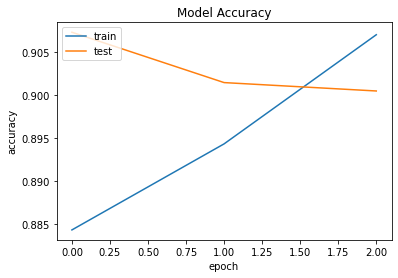

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

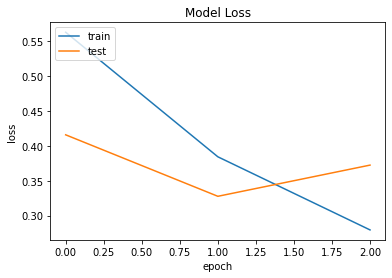

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Sebagian code mengambil referensi dari modul dan internet, harap dimaklumi jika terdapat beberapa kesamaan code 🙏😄~
Dan apabaila submission saya masih belum memenuhi ⭐5 harap di reject dan beritahukan saya yang kurang ~
Saya juga sangat menantikan feedback dari kakak kakak untuk menyempurnakan coding saya ~  Terimakasihh ~

Link Dataset

-https://drive.google.com/file/d/1p4Y-T2TAYh22WbjgJYTTXjKWmhe_W16r/view?usp=sharing

-https://www.kaggle.com/datasets/kulitekno/tokopedia-product-review-category-food-and-drink